#Masked Face Classification With Image Augmentation

##Graphics

In [ ]:
!nvidia-smi

Tue Jan  5 19:02:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp -R /content/drive/MyDrive/Face_Masked_Dataset/ /content/

# Importing packages

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

## Understanding our data

In [ ]:
num_faces_tr = len(os.listdir('/content/Face_Masked_Dataset/Train/Faces'))
num_masked_tr = len(os.listdir('/content/Face_Masked_Dataset/Train/Masked'))

num_faces_val = len(os.listdir('/content/Face_Masked_Dataset/validation/Faces'))
num_masked_val = len(os.listdir('/content/Face_Masked_Dataset/validation/Masked'))

total_train = num_faces_tr + num_masked_tr
total_val = num_faces_val + num_masked_val

In [ ]:
print('total training Faces images:', num_faces_tr)
print('total training masked images:', num_masked_tr)

print('total validation faces images:', num_faces_val)
print('total validation masked images:', num_masked_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Faces images: 1709
total training dog images: 1930
total validation cat images: 304
total validation dog images: 300
--
Total training images: 3639
Total validation images: 604


# Setting Model Parameters

In [ ]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 120  # Our training data consists of images with width of 120 pixels and height of 150 pixels

# Data Preparation 

In [ ]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory='/content/Face_Masked_Dataset/Train',
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(120,120)
                                                           class_mode='binary')

Found 3639 images belonging to 2 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory='/content/Face_Masked_Dataset/validation',
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 604 images belonging to 2 classes.


### Visualizing Training images

In [ ]:
sample_training_images, _ = next(train_data_gen) 

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

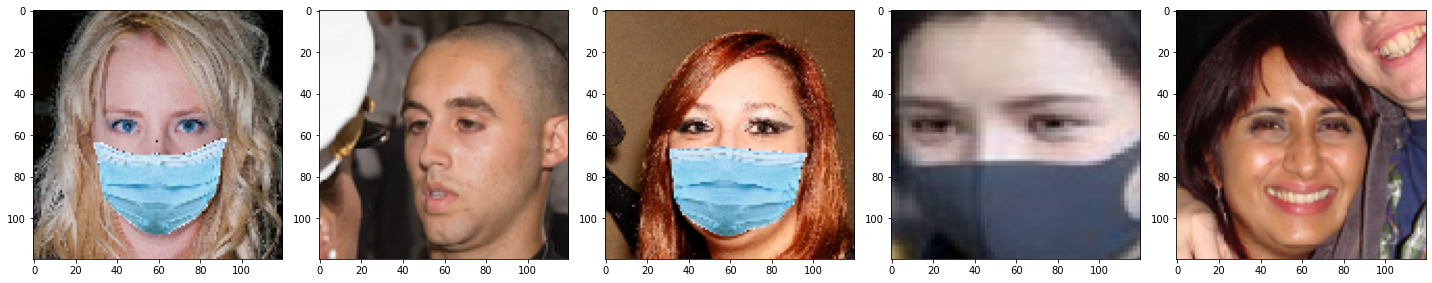

In [ ]:
plotImages(sample_training_images[:5])  # Plot images 0-4

#Data Augmentation

## Flipping

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory='/content/Face_Masked_Dataset/Train',
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 3639 images belonging to 2 classes.


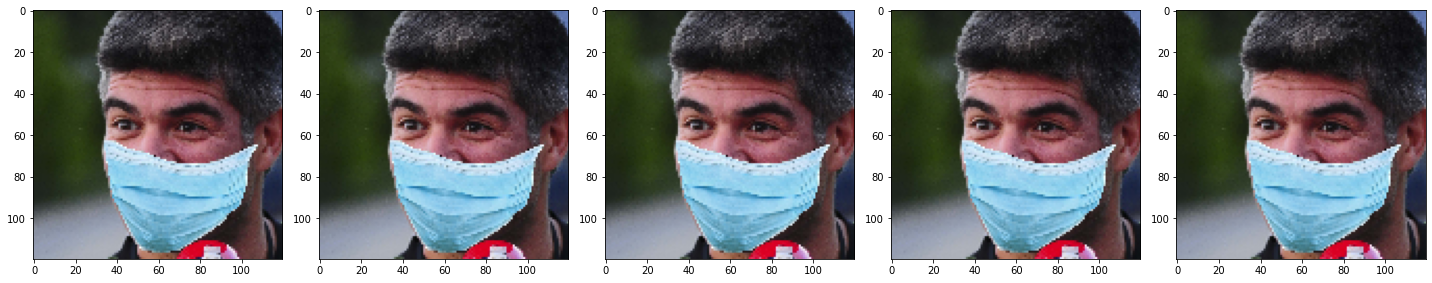

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##Ratation

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory='/content/Face_Masked_Dataset/Train',
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 3639 images belonging to 2 classes.


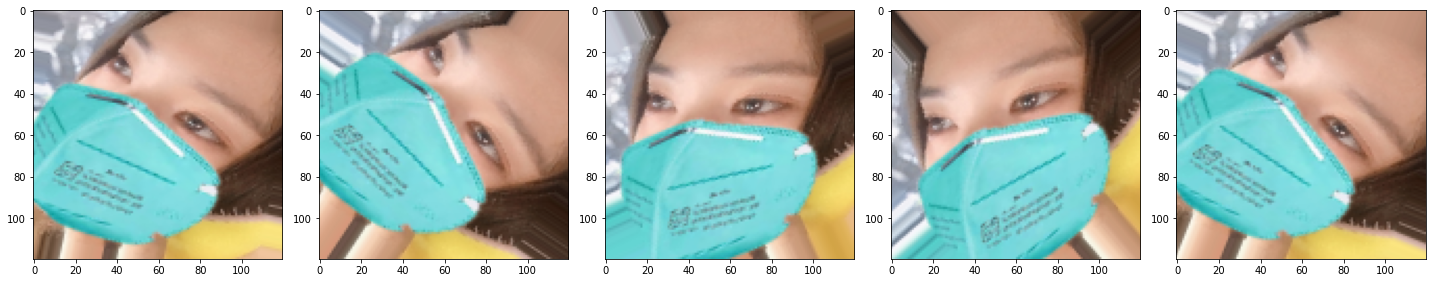

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

##Zooming

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory='/content/Face_Masked_Dataset/Train',
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 3639 images belonging to 2 classes.


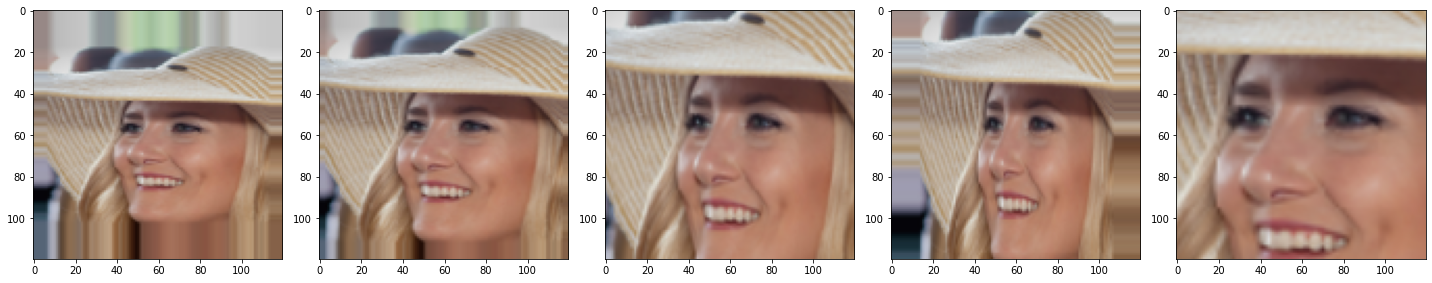

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#Image Generator

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory='/content/Face_Masked_Dataset/Train',
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 3639 images belonging to 2 classes.


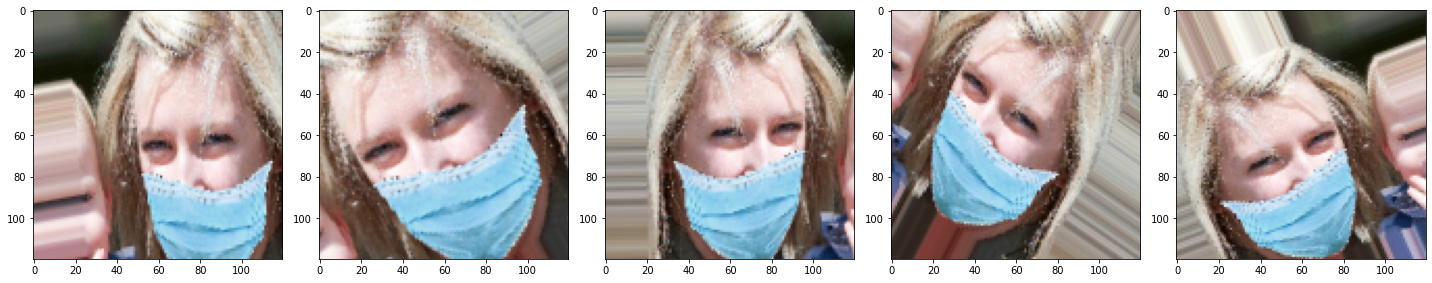

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory='/content/Face_Masked_Dataset/validation',
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 604 images belonging to 2 classes.


# Model Creation

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(120, 120, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
    #tf.keras.layers.Dense(2, activation='softmax')
    #tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#sigmoid

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       1

In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
37/37 [==============================] - 46s 1s/step - loss: 0.5944 - accuracy: 0.6885 - val_loss: 0.0927 - val_accuracy: 0.9801
Epoch 2/20
37/37 [==============================] - 42s 1s/step - loss: 0.1584 - accuracy: 0.9428 - val_loss: 0.0631 - val_accuracy: 0.9785
Epoch 3/20
37/37 [==============================] - 42s 1s/step - loss: 0.1316 - accuracy: 0.9549 - val_loss: 0.0435 - val_accuracy: 0.9851
Epoch 4/20
37/37 [==============================] - 41s 1s/step - loss: 0.1196 - accuracy: 0.9568 - val_loss: 0.0527 - val_accuracy: 0.9768
Epoch 5/20
37/37 [==============================] - 41s 1s/step - loss: 0.1330 - accuracy: 0.9544 - val_loss: 0.0496 - val_accuracy: 0.9818
Epoch 6/20
37/37 [==============================] - 41s 1s/step - loss: 0.1005 - accuracy: 0.9675 - val_loss: 0.0716 - val_accuracy: 0.9719
Epoch 7/20
37/37 [==============================] - 41s 1s/step - loss: 0.0986 - accuracy: 0.9647 - val_loss: 0.0412 - val_accuracy: 0.9834
Epoch 8/20
37/37 [==

### Visualizing results of the training

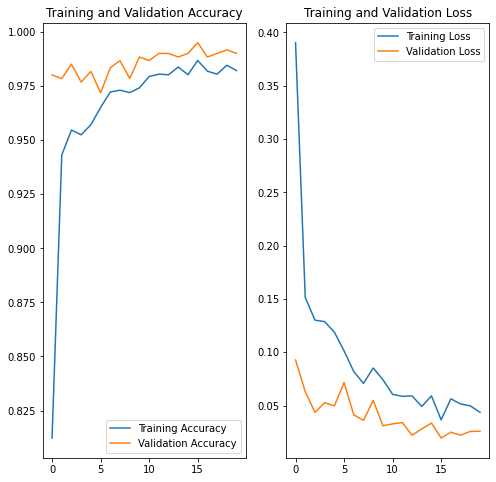

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()